In [551]:
%matplotlib inline

from __future__ import print_function
from __future__ import division

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from statsmodels.tools import eval_measures

In [552]:
def preprocess_data(data_path, labels_path=None):
    # load data and set index to city, year, weekofyear
    df = pd.read_csv(data_path, index_col=[0, 1, 2])
    df.drop('week_start_date', axis=1, inplace=True)
    df['constant'] = 1.0
    # fill missing values
    df.fillna(method='ffill', inplace=True)

    
    # add labels to dataframe
    if labels_path:
        labels = pd.read_csv(labels_path, index_col=[0, 1, 2])
        df = df.join(labels)
    
    # separate san juan and iquitos
    sj = df.loc['sj']
    iq = df.loc['iq']
    
    return sj, iq

In [553]:
def feature_normalization(train, test_sets, exclude=['total_cases', 'constant']):
    """Rescale the data so that each feature in the training set is in
    the interval [0,1], and apply the same transformations to the test
    set, using the statistics computed on the training set.

    Args:
        train - training set, a 2D numpy array of size (num_instances, num_features)
        test  - test set, a 2D numpy array of size (num_instances, num_features)
    Returns:
        train_normalized - training set after normalization
        test_normalized  - test set after normalization

    """
    for column in train:
        if column not in exclude:
            train_col = train.loc[:, column]
            train_mean = train_col.mean()
            train_std = train_col.std()
            train.loc[:, column] = (train_col - train_mean) / train_std
            for t in test_sets:
                t.loc[:, column] = (t.loc[:, column] - train_mean) / train_std


In [554]:
sj_train, iq_train = preprocess_data('data/dengue_features_train.csv',
                                    labels_path="data/dengue_labels_train.csv")
sj_test, iq_test = preprocess_data('data/dengue_features_test.csv')

In [555]:
sj_train_subtrain = sj_train.head(800)
sj_train_subtest = sj_train.tail(sj_train.shape[0] - 800)
feature_normalization(sj_train_subtrain, [sj_train_subtest, sj_test])

iq_train_subtrain = iq_train.head(400)
iq_train_subtest = iq_train.tail(iq_train.shape[0] - 400)
feature_normalization(iq_train_subtrain, [iq_train_subtest, iq_test])


In [556]:
def generic_gradient_checker(X, y, theta, objective_func, gradient_func, epsilon=0.01, tolerance=1e-4):
    """
    The functions takes objective_func and gradient_func as parameters. And check whether gradient_func(X, y, theta) returned
    the true gradient for objective_func(X, y, theta).
    Eg: In LSR, the objective_func = compute_square_loss, and gradient_func = compute_square_loss_gradient
    """
    true_gradient = gradient_func(X, y, theta) #the true gradient
    num_features = theta.shape[0]
    approx_grad = np.zeros(num_features) #Initialize the gradient we approximate
    for i in range(num_features):
        delta = np.zeros((num_features))
        delta[i] = epsilon
        hi = objective_func(X, y, theta + delta)
        lo = objective_func(X, y, theta - delta)
        approx_grad[i] = (hi - lo)/(2 * epsilon)
    return np.linalg.norm(approx_grad - true_gradient) < tolerance


In [584]:
def generic_gradient(X, y, theta, objective_func, epsilon=0.001):
    num_features = theta.shape[0]
    approx_grad = np.zeros(num_features) #Initialize the gradient we approximate
    for i in range(num_features):
        delta = np.zeros((num_features))
        delta[i] = epsilon
        hi = objective_func(X, y, theta + delta)
        lo = objective_func(X, y, theta - delta)
        approx_grad[i] = (hi - lo)/(2 * epsilon)
    return approx_grad

In [558]:
def compute_square_loss(X, y, theta):
    loss = 1.0/(2*len(y)) * np.linalg.norm(np.exp(np.dot(X, theta)) - y) ** 2
    return loss

def compute_absolute_loss(X, y, theta):
    loss = 1.0/(2*len(y)) * np.sum(np.abs(np.exp(np.dot(X, theta)) - y))
    return loss


In [559]:
def compute_square_loss_gradient(X, y, theta):
    exp_Xtheta = np.exp(np.dot(X, theta))
    grad = 1.0 / len(y) * np.dot(exp_Xtheta - y, np.transpose(np.transpose(X) * exp_Xtheta))
    return grad

In [560]:
def batch_grad_descent(X, y, X_test=None, y_test=None, alpha=0.1, num_iter=1000, check_gradient=False):
    """
    In this question you will implement batch gradient descent to
    minimize the square loss objective

    Args:
        X - the feature vector, 2D numpy array of size (num_instances, num_features)
        y - the label vector, 1D numpy array of size (num_instances)
        alpha - step size in gradient descent
        num_iter - number of iterations to run
        check_gradient - a boolean value indicating whether checking the gradient when updating

    Returns:
        theta_hist - store the the history of parameter vector in iteration, 2D numpy array of size (num_iter+1, num_features)
                    for instance, theta in iteration 0 should be theta_hist[0], theta in ieration (num_iter) is theta_hist[-1]
        loss_hist - the history of objective function vector, 1D numpy array of size (num_iter+1)
    """
    num_instances, num_features = X.shape[0], X.shape[1]
    print(X.shape)
    theta_hist = np.zeros((num_iter+1, num_features))  #Initialize theta_hist
    loss_hist = np.zeros(num_iter+1) #initialize loss_hist
    theta = np.ones(num_features)/20 #initialize theta
    theta_hist[0] = theta
    loss_hist[0] = compute_absolute_loss(X, y, theta)
    for i in range(num_iter):
        theta = theta - alpha * generic_gradient(X, y, theta, compute_absolute_loss)
        # theta = theta - alpha * compute_square_loss_gradient(X, y, theta)
        # if check_gradient and not generic_gradient_checker(X, y, theta, compute_square_loss, compute_square_loss_gradient):
        #    print("warning: gradient check fails")
        #    return
        theta_hist[i+1] = theta
        loss_hist[i+1] = compute_absolute_loss(X, y, theta)
    
    if X_test is not None:
        results = np.exp(np.dot(X_test, theta))
        print(eval_measures.meanabs(results, y_test))
    return theta_hist, loss_hist

In [627]:
# X = sj_train_subtrain.drop('total_cases', axis=1).as_matrix()
X = sj_train_subtrain[["reanalysis_specific_humidity_g_per_kg",
                     "reanalysis_dew_point_temp_k",
                     "station_min_temp_c",
                     "station_avg_temp_c",
                     "constant"]].as_matrix()
y = sj_train_subtrain['total_cases'].as_matrix()
# X_test = sj_train_subtest.drop('total_cases', axis=1).as_matrix()
X_test = sj_train_subtest[["reanalysis_specific_humidity_g_per_kg",
                           "reanalysis_dew_point_temp_k",
                           "station_min_temp_c",
                           "station_avg_temp_c",
                           "constant"]].as_matrix()
y_test = sj_train_subtest['total_cases'].as_matrix()
sj_thist, sj_lhist = batch_grad_descent(X, y, X_test=X_test, y_test=y_test, alpha=.01, num_iter=10000, check_gradient=False)
sj_train_subtrain['fitted'] = np.exp(np.dot(X, sj_thist[-1]))

/Users/alex/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(800, 5)
17.377223604

In [564]:
sj_lhist[1]

17.401567342919275

In [630]:
# X = iq_train_subtrain.drop('total_cases', axis=1).as_matrix()
X = iq_train_subtrain[["reanalysis_specific_humidity_g_per_kg",
                     "reanalysis_dew_point_temp_k",
                     "station_min_temp_c",
                     "station_avg_temp_c",
                     "constant"]].as_matrix()
y = iq_train_subtrain['total_cases'].as_matrix()
# X_test = iq_train_subtest.drop('total_cases', axis=1).as_matrix()
X_test = iq_train_subtest[["reanalysis_specific_humidity_g_per_kg",
                           "reanalysis_dew_point_temp_k",
                           "station_min_temp_c",
                           "station_avg_temp_c",
                           "constant"]].as_matrix()
y_test = iq_train_subtest['total_cases'].as_matrix()
iq_thist, iq_lhist = batch_grad_descent(X, y, X_test=X_test, y_test=y_test, alpha=.01, num_iter=10000, check_gradient=False)
iq_train_subtrain['fitted'] = np.exp(np.dot(X, iq_thist[-1]))


/Users/alex/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(400, 5)
6.09811908563

In [633]:

X_test = sj_test[["reanalysis_specific_humidity_g_per_kg",
                           "reanalysis_dew_point_temp_k",
                           "station_min_temp_c",
                           "station_avg_temp_c",
                           "constant"]].as_matrix()
sj_predictions = np.exp(np.dot(X_test, sj_thist[-1])).round().astype(int)
X_test = iq_test[["reanalysis_specific_humidity_g_per_kg",
                           "reanalysis_dew_point_temp_k",
                           "station_min_temp_c",
                           "station_avg_temp_c",
                           "constant"]].as_matrix()
iq_predictions = np.exp(np.dot(X_test, iq_thist[-1])).round().astype(int)

submission = pd.read_csv("data/submission_format.csv",
                         index_col=[0, 1, 2])

submission.total_cases = np.concatenate([sj_predictions, iq_predictions])
submission.to_csv("data/submission.csv")

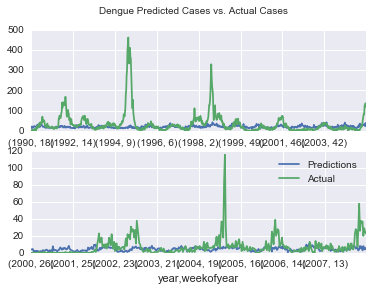

In [634]:

figs, axes = plt.subplots(nrows=2, ncols=1)

# plot sj
sj_train_subtrain.fitted.plot(ax=axes[0], label="Predictions")
sj_train_subtrain.total_cases.plot(ax=axes[0], label="Actual")

# plot iq
iq_train_subtrain.fitted.plot(ax=axes[1], label="Predictions")
iq_train_subtrain.total_cases.plot(ax=axes[1], label="Actual")

plt.suptitle("Dengue Predicted Cases vs. Actual Cases")
plt.legend()